In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt
from PIL import Image

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [4]:
def get_B_and_weight_vec(matrix,threshold):
    N = matrix.shape[0]
    A = matrix

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold:   
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return B, weight_vec

In [6]:
def algorithm(B, weight_vec, seeds,K=15000,alpha=0.02, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    seednodesindicator= np.zeros(N)
    seednodesindicator[seeds] = 1        


    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[seeds] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[seeds] = (newx[seeds] + Gamma_vec[seeds]) / (1 + Gamma_vec[seeds])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
    
    

In [59]:
img=Image.open("seven.png")

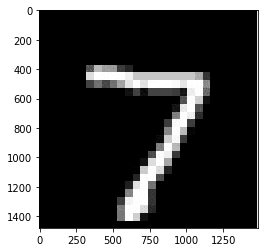

In [60]:
plt.imshow(img)

In [90]:
seven = np.array(img.resize((30,30)))
seven_seeds = np.copy(seven)
seven.max()

21

In [92]:
seven_seeds[20:23,15:17]=30
seven_seeds[2:7,20:24]=30
Image.fromarray(seven_seeds*10).save('seven_seeds.png')

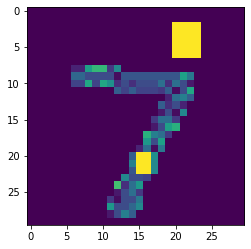

In [93]:
plt.imshow(seven_seeds.reshape((30,30)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':


(array([101883.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 708117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

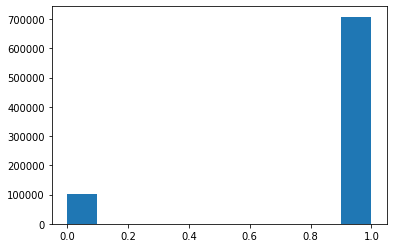

In [89]:
# generate similarity matrix by using equation (1)
sigma = 100
s_matrix = np.zeros((900,900))
for i in range(900):
    for j in range(900):
        if i==j:
            continue
        else:
            s_matrix[i][j] = np.exp((-(seven.flatten()[i]-seven.flatten()[j])**2)/(2*sigma**2)) # Equation 1

plt.hist(s_matrix.flatten())  #distribution of similarity measure

In [95]:
def run_seg(matrix,seeds,threshold, K=30, alpha=0.1, lambda_nLasso=0.1):
    B, weight_vec = get_B_and_weight_vec(matrix,threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec, seeds=seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)    
    return history

In [96]:
#get seeds indices
seeds = np.random.choice(np.argwhere(seven_seeds.flatten()==30).squeeze(),10)
seeds

array([140, 142, 676, 616, 645, 141, 675,  80, 113,  80])

our method time:  0:00:00.302970


<BarContainer object of 900 artists>

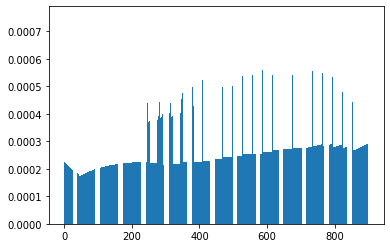

In [97]:
history = run_seg(s_matrix,seeds=seeds,threshold = 0.9, K=20,alpha=0.01, lambda_nLasso=0.1)
plt.bar(range(900),history[-1].flatten())

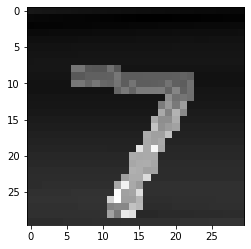

In [42]:
plt.imshow(history[-1].reshape(30,30),"gray")

In [41]:
# Run kmeans to achieve clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=0).fit(history[-1].reshape(len(history[-1]), 1))

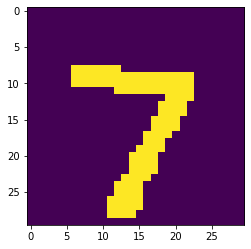

In [98]:
segmented = kmeans.labels_
plt.imshow(segmented.reshape((30,30)))  # run 20 iterations
plt.savefig('seven_seg.jpg')